In [9]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import seaborn as sns
import numpy as np
import json
import mpld3

#### nba_api is an API client package for ww.nba.com.
#### This package is meant to make the API endpoints more accessible.

In [5]:
HEADERS = {'user-agent': ('Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36'),
           'referer': 'http://stats.nba.com/scores/'
          }

In [ ]:
# Gathering all data points on career shot attempts
from nba_api.stats.endpoints import shotchartdetail 


seasons = []

#First, getting shot data from regular season
for season in range(1996,2016):
    seasonString = str(season) + '-' + str(season+1)[2:]
    
    #for regular season games
    shot_chart_reg = shotchartdetail.ShotChartDetail(context_measure_simple='FGA', team_id= 1610612747, player_id=977, season_nullable=seasonString, season_type_all_star='Regular Season')
    shot_df = shot_chart_reg.shot_chart_detail.get_data_frame()

    #convert to pandas DataFrame
    shot_df = pd.DataFrame(shot_df)
    
    # add extra column for season
    shot_df['SEASON'] = seasonString

    # add extra column for playoff flag
    shot_df['playoffs'] = 0
    
    seasons.append(shot_df)
   

    
#Doing the same thing for playoff games    
for season in range(1996,2016):
    seasonString = str(season) + '-' + str(season+1)[2:]


    shot_chart_playoffs = shotchartdetail.ShotChartDetail(context_measure_simple='FGA', team_id= 1610612747, player_id=977,season_nullable=seasonString, season_type_all_star='Playoffs')
    
    shot_df = shot_chart_playoffs.shot_chart_detail.get_data_frame()
    
    shot_df = pd.DataFrame(shot_df)
    
    shot_df['SEASON'] = seasonString

    shot_df['playoffs'] = 1
    
    seasons.append(shot_df)
  



In [ ]:
#Concatenating all seasons into one pandas DataFrame
kobe_all_shots = pd.concat(seasons)



In [6]:
#Assuring that the df displays the correct number of shots for career
len(kobe_all_shots)


30697

In [3]:
# kobe_all_shots.to_csv('kobe_all_shots.csv')
kobe_all_shots = pd.read_csv('kobe_all_shots.csv')

kobe_all_shots = pd.DataFrame(kobe_all_shots)

In [4]:
kobe_all_shots.head()

,Unnamed: 0,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,...,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,SEASON,playoffs
0,0,Shot Chart Detail,29600027,102,977,Kobe Bryant,1610612747,Los Angeles Lakers,1,0,...,18,-140,116,1,0,19961103,LAL,MIN,1996-97,0
1,1,Shot Chart Detail,29600031,127,977,Kobe Bryant,1610612747,Los Angeles Lakers,2,10,...,16,-131,97,1,0,19961105,NYK,LAL,1996-97,0
2,2,Shot Chart Detail,29600044,124,977,Kobe Bryant,1610612747,Los Angeles Lakers,2,8,...,23,-142,181,1,1,19961106,CHH,LAL,1996-97,0
3,3,Shot Chart Detail,29600044,144,977,Kobe Bryant,1610612747,Los Angeles Lakers,2,6,...,0,0,0,1,0,19961106,CHH,LAL,1996-97,0
4,4,Shot Chart Detail,29600044,151,977,Kobe Bryant,1610612747,Los Angeles Lakers,2,5,...,13,-10,138,1,1,19961106,CHH,LAL,1996-97,0


In [5]:
# Combining NBA's distinct shot types into broader categories.

kobe_all_shots['COMBINED_SHOT_TYPE'] = kobe_all_shots['ACTION_TYPE']

kobe_all_shots.replace(to_replace={
    'COMBINED_SHOT_TYPE': {
         '(.+)?Jump (.+)?(S|s)hot':'Jump Shot',
            '(.+)?Fadeaway(.+)?':'Jump Shot',
            '(.+)?Dunk Shot':'Dunk',
            '(.+)?Layup (S|s)hot': "Layup",
            '(.+)?Hook.+':"Hook Shot",
            '(.+)?Tip.+':"Tip Shot",
            '(.+)?Bank.+':"Bank Shot",
            '(.+)?Finger Roll.+':"Layup"
    }
}, regex=True, inplace=True)

kobe_all_shots.COMBINED_SHOT_TYPE.value_counts()

Jump Shot    23485
Layup         5448
Dunk          1286
Tip Shot       184
Hook Shot      158
Bank Shot      136
Name: COMBINED_SHOT_TYPE, dtype: int64

In [6]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

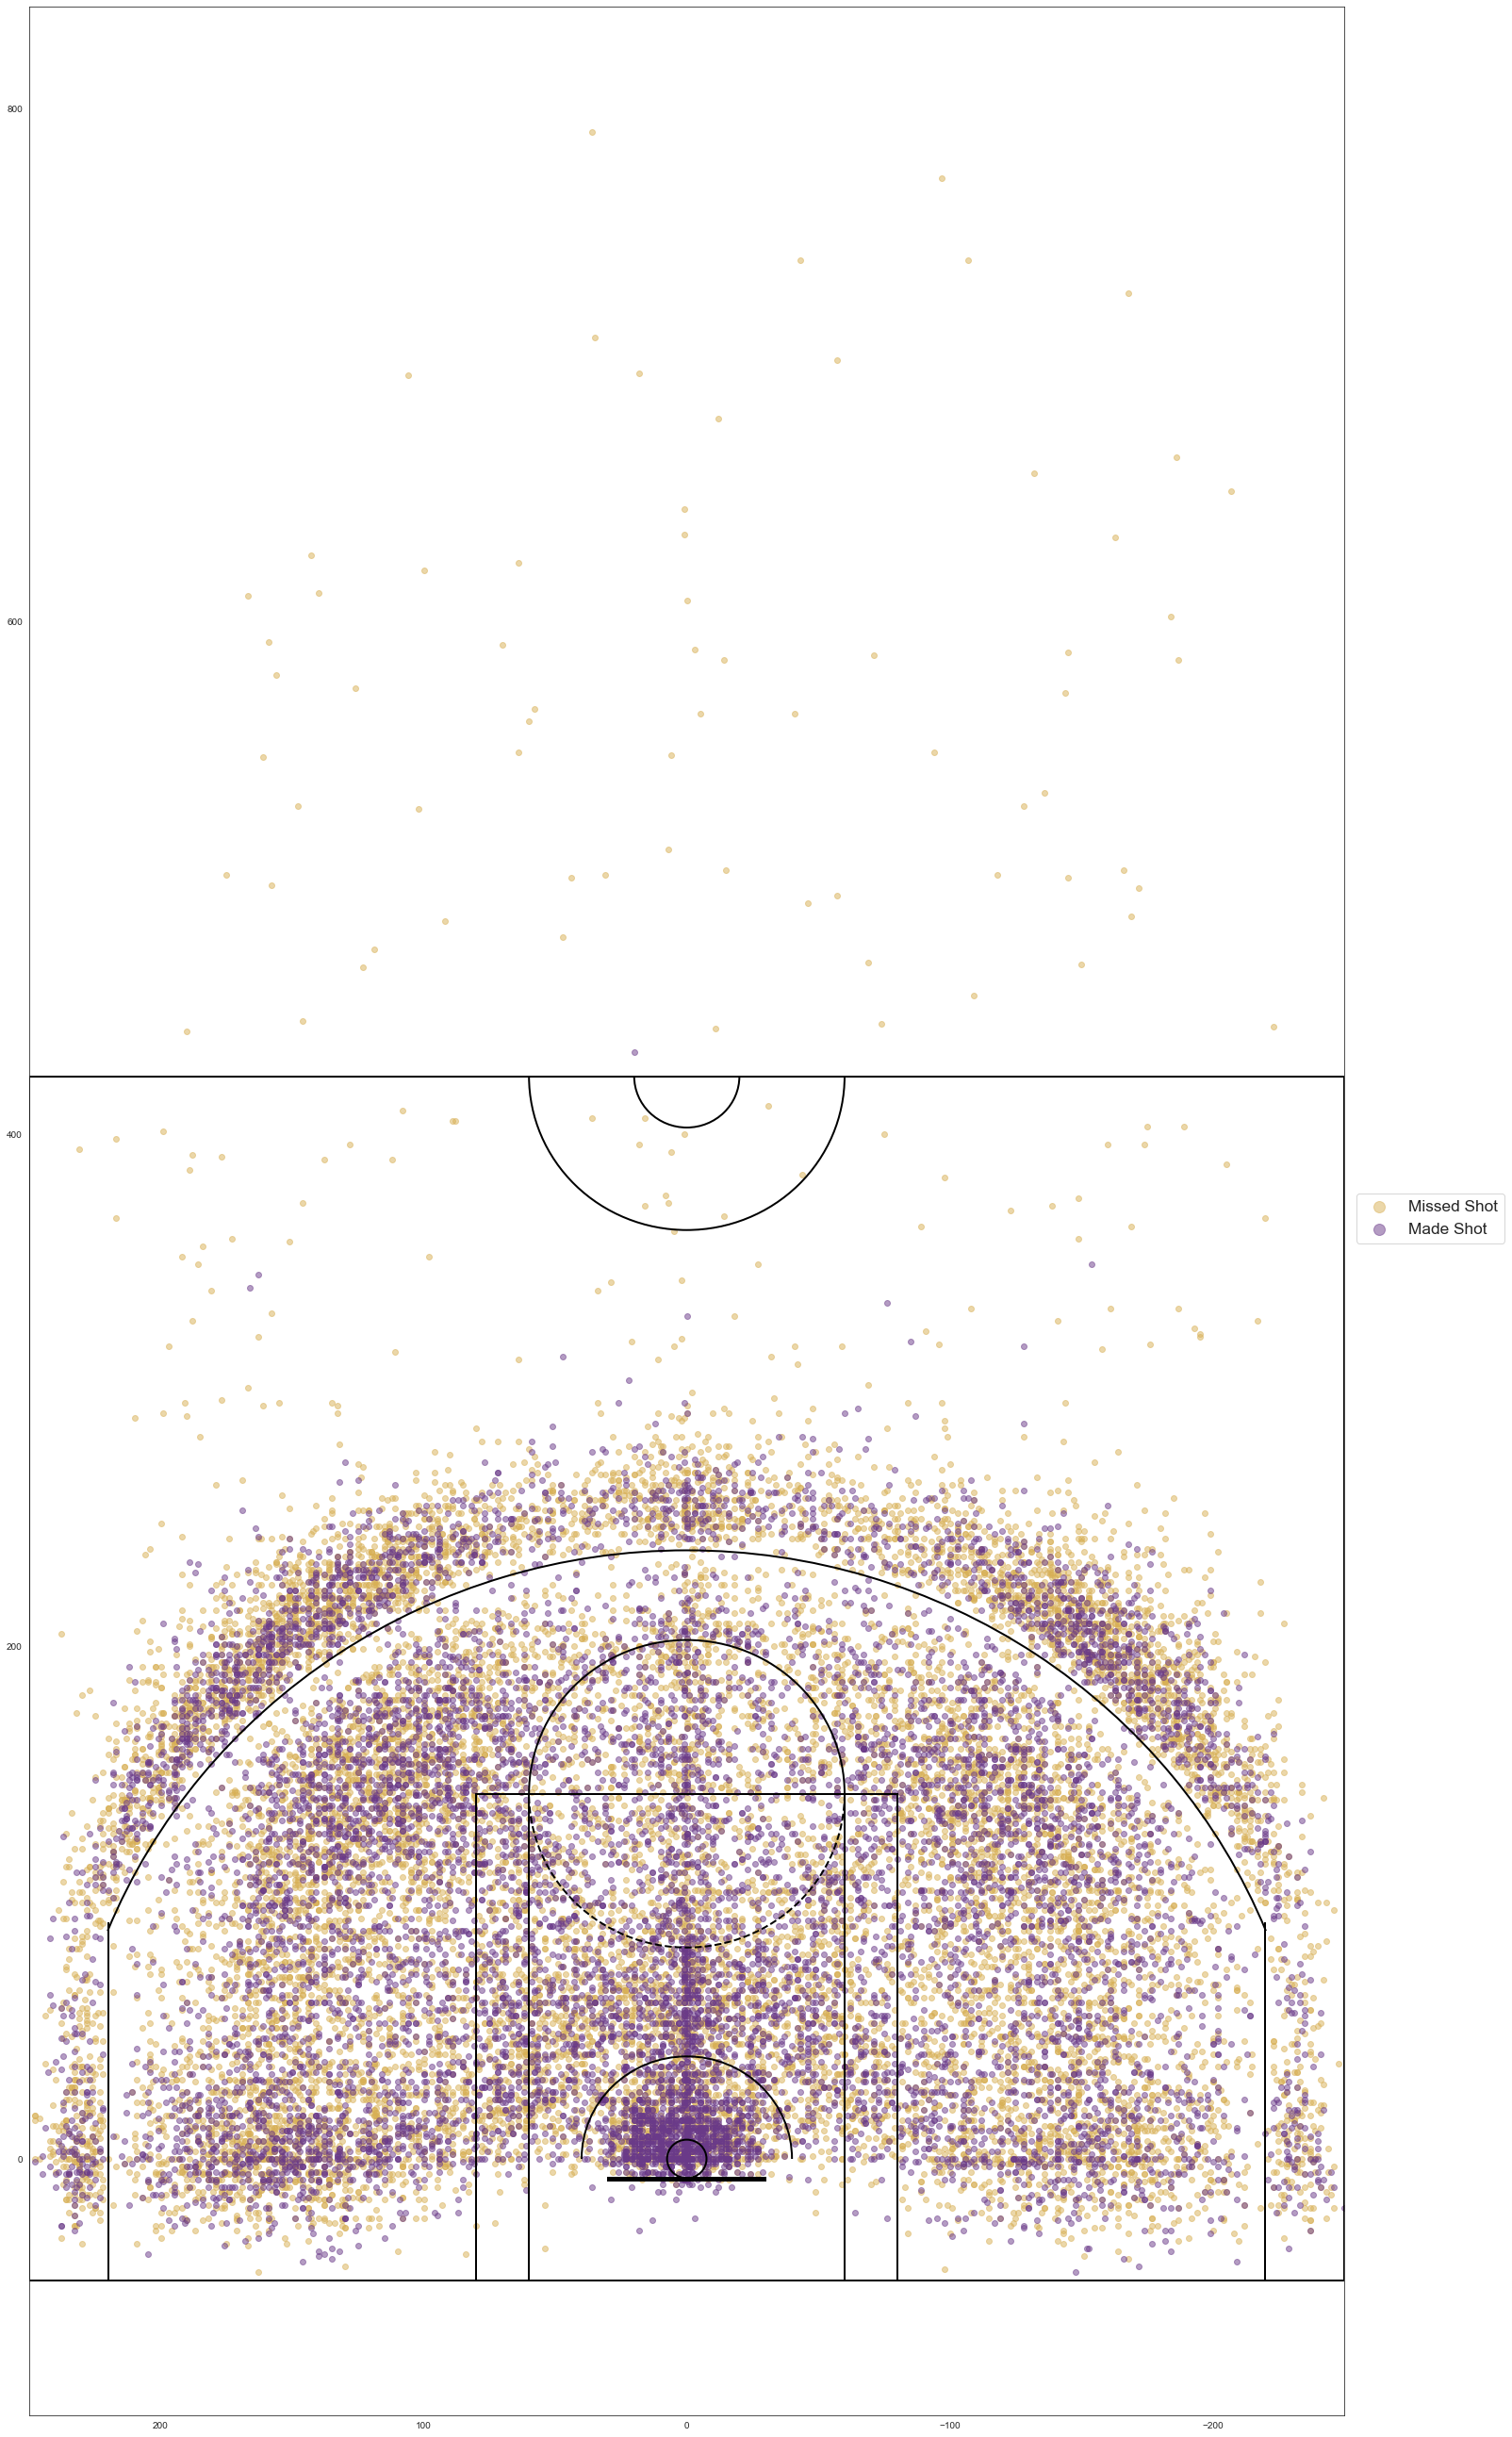

In [39]:
# plot all the shots
sns.set_style("white")
sns.set_color_codes()
all_shot_fig = plt.figure(figsize=(25,47),dpi=72)
all_shot_ax = all_shot_fig.add_subplot(111)

all_shot_ax.set_ylim([-100,840])
all_shot_ax.set_xlim([250,-250])

draw_court(ax=all_shot_ax,outer_lines=True)

# First, draw the missed shots
miss = all_shot_ax.scatter(kobe_all_shots[
        (kobe_all_shots.EVENT_TYPE == "Missed Shot")
    ].LOC_X,
    kobe_all_shots[
        (kobe_all_shots.EVENT_TYPE == "Missed Shot")
    ].LOC_Y,color='#d8b055',alpha=0.5, label = "Missed Shot")


# Then the made shots
make = all_shot_ax.scatter(kobe_all_shots[
        (kobe_all_shots.EVENT_TYPE == "Made Shot")
    ].LOC_X,
    kobe_all_shots[
        (kobe_all_shots.EVENT_TYPE == "Made Shot")
    ].LOC_Y,color='#6a3a89',alpha=0.5, label = "Made Shot")

# Add a legend to distinguish Made from Missed Shots
all_shot_fig.legend(loc='center right', fontsize='xx-large', markerscale=2)


#all_shot_fig.savefig('kobeshotchart.svg')